In [1]:
!pip install wandb

In [1]:
import math
import torch
import torch.nn as nn


class FourierLayer(nn.Module):
    """
    A torch.nn.Module child class that maps every input feature to n_fourier_features sines and n_fourier_features cosines with different (either linearly or exponentially growing) frequencies and concatenates the ouptuts.
    n_fourier_features is the number of pairs of sine/cosine outputs that every input feature is mapped to
    freq_spacing_type must be either 'logarithmic' or 'linear' and controls how the sine/cosine frequencies are spaced ('logarithmic' is recommended and typically performs a lot better)
    fan_in is an optional argument controlling how many inputs the layer will get. if provided, the FourierLayer.out_dim will be an integer storing the output size. otherwise, it will be None
    no_grad controls whether the input is allowed to have requires_grad = True. no_grad = True -> not allowed
    """
    def __init__(self, n_fourier_features: int, freq_spacing_type: str = 'logarithmic', fan_in: int = None, no_grad: bool = True):
        super().__init__()
        assert freq_spacing_type in {'logarithmic', 'linear'}, f'Unknown frequency spacing type: {self.freq_spacing_type}'
        self.n_fourier_features = n_fourier_features
        self.fan_in = fan_in
        if fan_in is not None:
            self.out_dim = 2 * fan_in * self.n_fourier_features
        else:
            self.out_dim = None
        self.freq_spacing_type = freq_spacing_type
        self.no_grad = no_grad

    @staticmethod
    def get_output_size(input_size: int, n_fourier_features: int):
        return 2 * input_size * n_fourier_features

    def forward_fn(self, x):
        x = x.view(x.shape + (1,))
        if self.freq_spacing_type == 'logarithmic':
            feature_mul = math.pi * 2 ** torch.arange(0, self.n_fourier_features, device=x.device)
        else:
            feature_mul = math.pi * torch.arange(1, self.n_fourier_features + 1, device=x.device)
        sines = torch.sin(x * feature_mul)
        cosines = torch.cos(x * feature_mul)
        del feature_mul
        # sines.shape = cosines.shape
        out = (torch.concat([
            sines.view(sines.shape + (1,)),
            cosines.view(cosines.shape + (1,))
        ],
            dim=-1)
               .flatten(-3, -1)
               )
        del sines, cosines
        return out

    def forward(self, x) -> torch.Tensor:
        assert x.size(-1) == self.fan_in, "fan_in provided at initialization does not match size of input tensor"
        assert not (self.no_grad and x.requires_grad), "FourierLayer is set to no_grad = True, but input requires grad."
        if self.no_grad:
            with torch.no_grad():
                return self.forward_fn(x).detach()
        return self.forward_fn(x)


In [2]:
import json
import random
import torch
from torch import nn
from torch.nn import functional as F


# implement this class yourself for your model!
class Model(nn.Module):
    def __init__(self, fan_in: int, fan_out: int):
        super(Model, self).__init__()
        with open('3d/hyperparameters.json') as f:
            hyperparams = json.load(f)['model.py']  # only load the hyperparameters that are meant to be used in this file
        self.fan_in = fan_in
        self.fan_out = fan_out
        self.fourier_layer = FourierLayer(hyperparams['n_fourier_features'], fan_in=fan_in)
        self.act = nn.LeakyReLU(inplace=True)
        self.fc1 = nn.Linear(self.fourier_layer.out_dim, hyperparams['n_hidden'])
        self.fc2 = nn.Linear(hyperparams['n_hidden'], hyperparams['n_hidden'])
        self.fc3 = nn.Linear(hyperparams['n_hidden'], hyperparams['n_hidden'])
        self.fc4 = nn.Linear(hyperparams['n_hidden'], fan_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fourier_layer(x)

        # model here
        # -------
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        x = self.act(x)
        x = self.fc4(x)
        # -------
        x = F.sigmoid(2 * x)  # 2 * x to make sigmoid steeper for gradients
        return x


In [ ]:
import os
import shutil


def move_files(source_dir, destination_dir):
    # List all files in the source directory
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    for file_name in files:
        source_path = os.path.join(source_dir, file_name)
        destination_path = os.path.join(destination_dir, file_name)

        # Move the file
        shutil.move(source_path, destination_path)
        print(f"Moved {file_name} to {destination_dir}")


def remove_files(dir):
    files = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]

    for file_name in files:
        source_path = os.path.join(dir, file_name)
        os.remove(source_path)


source_directory = "./"  # Current execution directory
destination_directory = "3d/views/"

move_files(source_directory, destination_directory)
#remove_files(source_directory)  # not needed because move_files does it too

In [4]:
import json
import argparse
import random
import torch
from torch.nn import functional as F
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
import wandb


def factorize_with_smallest_difference(n):
    factors = []

    for i in range(1, int(n ** 0.5) + 1):
        if n % i == 0:
            factors.append((i, n // i))

    best_factors = min(factors, key=lambda pair: abs(pair[0] - pair[1]))

    return best_factors


"""parser = argparse.ArgumentParser()
parser.add_argument('--path', type=str, default='views', help="path to .json file containing the image info")
parser.add_argument('--train', action='store_true', help="train a new model")
parser.add_argument('--eval', action='store_true', help="evaluate currently saved model")
parser.add_argument('--resume', action='store_true', help="continue training currently saved model")
parser.add_argument('--cuda', action='store_true', help="use cuda for training")
parser.add_argument('--verbose', action='store_true', help="print epoch to console")
parser.add_argument('--wandb', type=str, default=None, help="wandb project to log this run to")
args = parser.parse_args()"""
args = argparse.Namespace(
    path="views",
    train=True,
    eval=False,
    resume=False,
    cuda=True,
    verbose=True,
    wandb="arxiv_2006.10739"
)

assert args.train or args.eval or args.resume, "You must provide one of --train, --eval or --resume"
assert sum(
    map(int, [args.train, args.eval, args.resume])) == 1, "You must provide only one of --train, --eval or --resume"

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load hyperparams from file
with open('3d/hyperparameters.json') as f:
    hyperparams_dict = json.load(f)
    hyperparams = argparse.Namespace(**hyperparams_dict['main.py'])

assert sum([hyperparams.split_distribution[k] for k in
            ["train", "validation", "test"]]) == 1, "Split distribution (in hyperparameters.json) must sum to 1."
assert hyperparams.checkpoint_metric in ["train_loss",
                                         "validation_loss"], "Checkpoint metric must be one of 'train_loss' or 'validation_loss'"

if args.wandb is not None:
    wandb.login(anonymous='allow')
    if args.train or args.resume:
        wandb.init(
            project=args.wandb,
            config=hyperparams_dict
        )
    else:
        wandb.init(
            project=args.wandb
        )

# load images
pics, cam_pos, cam_rot = [], [], []
json_fn = None
for fn in os.listdir(f"3d/{args.path}/"):
    if fn.endswith('.json'):
        assert json_fn is None, "More than one json file in data directory. Remove all but the necessary one."
        json_fn = fn

assert json_fn is not None, "Could not find a json file containing dataset info"

with open(f"3d/{args.path}/{json_fn}") as f:
    data_json = json.load(f)

for x in data_json:
    pic = Image.open("3d/" + x["image"]).convert('RGB')
    pic = transform(pic).permute((2, 1, 0)).unsqueeze(0)
    pics.append(pic)
    pos = torch.tensor(list(map(float, x["position"].split(', '))))
    cam_pos.append(pos)
    rot = torch.tensor(list(map(float, x["rotation"].split(', '))))
    cam_rot.append(rot)

assert all([i.shape == j.shape for i, j in zip(pics, pics[1:])]), "Not all images have the same shape."
pics = torch.concat(pics)
cam_pos = torch.stack(cam_pos)
cam_rot = torch.stack(cam_rot)

if hyperparams.batch_size == -1:
    hyperparams.batch_size = pics.shape[0]
assert pics.shape[
           0] % hyperparams.batch_size == 0, f"Cannot divide {pics.shape[0]} images evenly into {hyperparams.batch_size} groups"
assert pics.shape[
           1] % hyperparams.n_image_splits == 0, f"Cannot horizontally divide images of horizontal size {pics.shape[1]} evenly into {hyperparams.n_image_splits} equal segments"

# define model input
# pure pixel position input + reshape
'''
model_in = torch.concat(
    [torch.arange(pics.shape[1]).unsqueeze(-1).repeat_interleave(pics.shape[2], dim=1).unsqueeze(-1),
     torch.arange(pics.shape[2]).unsqueeze(0).repeat_interleave(pics.shape[1], dim=0).unsqueeze(-1)],
    dim=-1) / torch.tensor(list(pics.shape[1:-1])) * 2 - 1

Does the same thing (but worse) as:
'''
model_in = torch.stack(
    [
        torch.linspace(-1, 1, pics.shape[1]).unsqueeze(-1).repeat_interleave(pics.shape[2], dim=1),
        torch.linspace(-1, 1, pics.shape[2]).unsqueeze(0).repeat_interleave(pics.shape[1], dim=0)
    ],
    dim=-1
)
model_in = model_in.unsqueeze(0).repeat_interleave(pics.shape[0], dim=0)
# reshape camera position and rotation
cam_pos = (cam_pos.view((cam_pos.shape[0], 1, 1, cam_pos.shape[1]))
           .repeat_interleave(model_in.shape[1], dim=1)
           .repeat_interleave(model_in.shape[2], dim=2))
cam_rot = (cam_rot.view((cam_rot.shape[0], 1, 1, cam_rot.shape[1]))
           .repeat_interleave(model_in.shape[1], dim=1)
           .repeat_interleave(model_in.shape[2], dim=2))
# concat
model_in = torch.concat([cam_pos, cam_rot, model_in], dim=-1)

assert model_in.shape[:-1] == pics.shape[
                              :-1], f"Model input and expected output do not align in shape. {model_in.shape[:-1]=}; {pics.shape[:-1]=}"

# randomly permute the data if program was launched in train or resume mode
if args.train or args.resume:
    for dim in range(model_in.dim() - 1):
        size = model_in.size(dim)
        permutation = torch.randperm(size)
        model_in = model_in.index_select(dim, permutation)
        pics = pics.index_select(dim, permutation)

# split model_in into pieces because it requires 600GiB GPU RAM otherwise D:
X = []
Y = []
x_batch_splits = model_in.split(hyperparams.batch_size)
y_batch_splits = pics.split(hyperparams.batch_size)

for x_batch_split, y_batch_split in zip(x_batch_splits, y_batch_splits):
    X.extend(x_batch_split.split(x_batch_split.shape[1] // hyperparams.n_image_splits, dim=1))
    Y.extend(y_batch_split.split(y_batch_split.shape[1] // hyperparams.n_image_splits, dim=1))

del x_batch_splits, y_batch_splits, x_batch_split, y_batch_split

# define the model
if args.train:
    model = Model(hyperparams.fan_in, hyperparams.fan_out)
else:
    model = torch.load('3d/model.ckpt')

# define the optimizer
optim = torch.optim.AdamW(model.parameters(), lr=0)
pred = None

# move to gpu
if args.cuda:
    if torch.cuda.is_available():
        # model_in = model_in.to('cuda')  not used anymore!!!
        for i, x in enumerate(X):
            X[i] = x.to('cuda')
        for i, y in enumerate(Y):
            Y[i] = y.to('cuda')
        model = model.to('cuda')
        # pics = pics.to('cuda')  not used anymore!!!
        print('Moved parameters/IO to cuda')
    else:
        raise Exception('Cuda not available -> Failed to move parameters/IO to cuda')

train_val_separation_index = int(len(X) * hyperparams.split_distribution["train"])
val_test_separation_index = int(train_val_separation_index + len(X) * hyperparams.split_distribution["validation"])

X_train, X_val, X_test, Y_train, Y_val, Y_test = (
    X[:train_val_separation_index],
    X[train_val_separation_index:val_test_separation_index],
    X[val_test_separation_index:],
    Y[:train_val_separation_index],
    Y[train_val_separation_index:val_test_separation_index],
    Y[val_test_separation_index:]
)

# delete unnecessary variables for gpu memory
del transform, pics, cam_pos, cam_rot, model_in, X, Y


def shuffle_x_y(X, Y):
    seed = random.getrandbits(64)
    random.seed(seed)
    random.shuffle(X)
    random.seed(seed)
    random.shuffle(Y)


def get_loss(X, Y) -> float:
    loss = 0
    for x, y in zip(X, Y):
        pred = model(x)
        L = F.mse_loss(pred, y)
        loss += L.item()
    loss /= len(X_val)
    return loss


def get_loss_and_preds(X, Y, detach_pred=False) -> tuple[float, torch.Tensor]:
    pred = []
    loss = 0
    for i, x, y in zip(range(len(X)), X, Y):
        if args.verbose:
            print(f"Eval sample {i}/{len(X)}")
        model_out = model(x)
        loss += F.mse_loss(model_out, y).item()
        if detach_pred:
            pred.append(model_out.to('cpu').detach())
        else:
            pred.append(model_out)
    loss /= len(X)
    pred = torch.concat(pred)
    return loss, pred


def fit_list_of_samples(X: list[torch.Tensor], Y: list[torch.Tensor], losses: list[list[list[float]]]):
    for i, x, y in zip(range(len(X)), X, Y):
        pred = model(x)
        L = F.mse_loss(pred, y)
        optim.zero_grad()
        L.backward()
        optim.step()
        losses[-1][-1].append(L.item())


# main training loop
if args.train or args.resume:
    losses = []
    n_epochs = 0
    best_checkpoint_loss = float('inf')
    train_loss, val_loss = float('NaN'), float('NaN')
    logged_with_val_loss = False
    print("Starting/resuming training...")
    for epoch_group_idx, lr_with_epochs in enumerate(hyperparams.learning_rates):
        losses.append([])
        for i in range(len(optim.param_groups)):
            optim.param_groups[i]['lr'] = lr_with_epochs['lr']
        for e in range(lr_with_epochs['epochs']):
            losses[-1].append([])
            shuffle_x_y(X_train, Y_train)  # shuffle the order of sample batches (not sure if useful)
            fit_list_of_samples(X_train, Y_train, losses)
            train_loss = sum(losses[-1][-1]) / len(losses[-1][-1])
            if args.verbose:
                print(f'Epoch {n_epochs}   Loss {train_loss}')
            n_epochs += 1

            if lr_with_epochs['checkpoints'] > 0:  # if you want to checkpoint at all
                if lr_with_epochs['checkpoints'] > lr_with_epochs['epochs']:
                    raise Exception(
                        f"In epoch group {epoch_group_idx}, checkpoints (={lr_with_epochs['checkpoints']}) was set to something higher than epochs (={lr_with_epochs['epochs']}). You cannot make more checkpoints than there are epochs!")
                else:
                    is_checkpoint_epoch = (e + 1) % (lr_with_epochs['epochs'] // lr_with_epochs['checkpoints']) == 0

                val_loss = get_loss(X_val, Y_val)

                if args.wandb is not None:
                    wandb.log({f"{'train' if args.train else 'resume'}/loss": train_loss,
                               f"{'train' if args.train else 'resume'}/lr": lr_with_epochs['lr'],
                               f"{'train' if args.train else 'resume'}/val_loss": val_loss})
                    logged_with_val_loss = True

                # if it's checkpoint time and the val loss is better than before
                if is_checkpoint_epoch and (
                        val_loss < best_checkpoint_loss if hyperparams.checkpoint_metric == 'validation_loss' else train_loss <= best_checkpoint_loss):  # want to checkpoint and loss is better than at the end of last checkpointed epoch group (an epoch group is a group of epochs with shared lr)
                    best_checkpoint_loss = val_loss if hyperparams.checkpoint_metric == 'validation_loss' else train_loss
                    torch.save(model, '3d/model.ckpt')
                    print("Saved the model to model.ckpt")

            if args.wandb is not None:
                if logged_with_val_loss:
                    logged_with_val_loss = False
                else:
                    wandb.log({f"{'train' if args.train else 'resume'}/loss": train_loss,
                               f"{'train' if args.train else 'resume'}/lr": lr_with_epochs['lr']})

    print("Training finished. Saving model if it's better than last checkpoint.")
    # sorry in advance to anyone who has to read the next line
    if val_loss < best_checkpoint_loss if hyperparams.checkpoint_metric == 'validation_loss' else train_loss <= best_checkpoint_loss:  # want to checkpoint and loss is better than at the end of last checkpointed epoch group (an epoch group is a group of epochs with shared lr)
        torch.save(model, '3d/model.ckpt')
        print("Saved the model to model.ckpt")

    test_loss = get_loss(X_test, Y_test)
    if args.wandb is not None:
        wandb.log({f"{'train' if args.train else 'resume'}/test_loss": test_loss})
        wandb.finish()
    print("Loss on test split:", test_loss)
else:
    print("Starting evaluation...")
    train_loss, pred_train = get_loss_and_preds(X_train, Y_train, detach_pred=True)
    val_loss, pred_val = get_loss_and_preds(X_val, Y_val, detach_pred=True)
    test_loss, pred_test = get_loss_and_preds(X_test, Y_test, detach_pred=True)
    print("Generating output plots...")
    # detach and split images (or parts of images if --n-image-splits is bigger than 1)
    imgs = torch.concat([pred_train, pred_val, pred_test], dim=0).to('cpu').transpose(2, 1).detach().numpy()
    split_labels = ["train" for _ in range(pred_train.size(0))] + ["validation" for _ in range(pred_val.size(0))] + [
        "test" for _ in range(pred_test.size(0))]

    del pred_train, pred_val, pred_test

    imgs = [imgs[i] for i in range(imgs.shape[0])]
    if args.wandb is not None:
        wandb_pred = [wandb.Image(img) for img in imgs]
        wandb_ground_truth = [wandb.Image(y.to('cpu').transpose(2, 1).detach().numpy()) for y in Y_train + Y_val + Y_test]
        wandb_eval_table = wandb.Table(columns=["prediction", "ground_truth", "split_label"],
                                       data=list(map(list, zip(wandb_pred, wandb_ground_truth, split_labels))))
        wandb.log({"eval/samples": wandb_eval_table, "eval/train_loss": train_loss, "eval/val_loss": val_loss,
                   "eval/test_loss": test_loss})
        wandb.finish()  # wandb is not going to be used later on anymore

    num_images = len(imgs)
    num_rows, num_cols = factorize_with_smallest_difference(num_images)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5))

    # Plot each image in its respective subplot
    for i in range(num_images):
        if num_images > 1:
            ax = axes[i]
        else:
            ax = axes  # Handle the case when there's only one image

        ax.imshow(imgs[i])
        ax.set_title(f'Image(/part) from split {split_labels[i]} {i + 1}')

    # Adjust layout to prevent overlapping titles and labels
    plt.tight_layout()
    print("Showing plots...")
    plt.show()


wandb: Currently logged in as: barni77. Use `wandb login --relogin` to force relogin


Moved parameters/IO to cuda
Starting/resuming training...
Epoch 0   Loss 0.2447333166996638
Epoch 1   Loss 0.2447333166996638
Epoch 2   Loss 0.2447333166996638
Epoch 3   Loss 0.2447333166996638
Epoch 4   Loss 0.0954629319254309
Epoch 5   Loss 0.08085734623794755
Epoch 6   Loss 0.07293653059750796
Epoch 7   Loss 0.07160208054507772
Epoch 8   Loss 0.07083303772378713
Epoch 9   Loss 0.07224382880764703
Epoch 10   Loss 0.07064853348225976
Epoch 11   Loss 0.07091663882990057
Epoch 12   Loss 0.07228060147802656
Epoch 13   Loss 0.07169695305638016
Epoch 14   Loss 0.06527195628344391
Epoch 15   Loss 0.06830874625593424
Epoch 16   Loss 0.06681640953756869
Epoch 17   Loss 0.07051611724697675
Epoch 18   Loss 0.06585814299760387
Epoch 19   Loss 0.06604684359626845
Epoch 20   Loss 0.07100962650729344
Epoch 21   Loss 0.05990373054131245
Epoch 22   Loss 0.06535940540488809
Epoch 23   Loss 0.058299546137762566
Epoch 24   Loss 0.06290999197323496
Epoch 25   Loss 0.06284077946717541
Epoch 26   Loss 0.05

KeyboardInterrupt: ignored

In [5]:
wandb.finish()

train/loss,███▄▃▃▃▃▃▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
train/lr,▁▁▁█████████████████████████████████████
train/val_loss,▁▂▄▃▂█▇▃▅▅▆▃▇▂▅▂▃▄▄▆▄▅▄▅▄▆▅▆▅▅▅▇▆▆▇▆▆▇▇█
train/loss,0.02016
train/lr,0.001
train/val_loss,0.09775


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


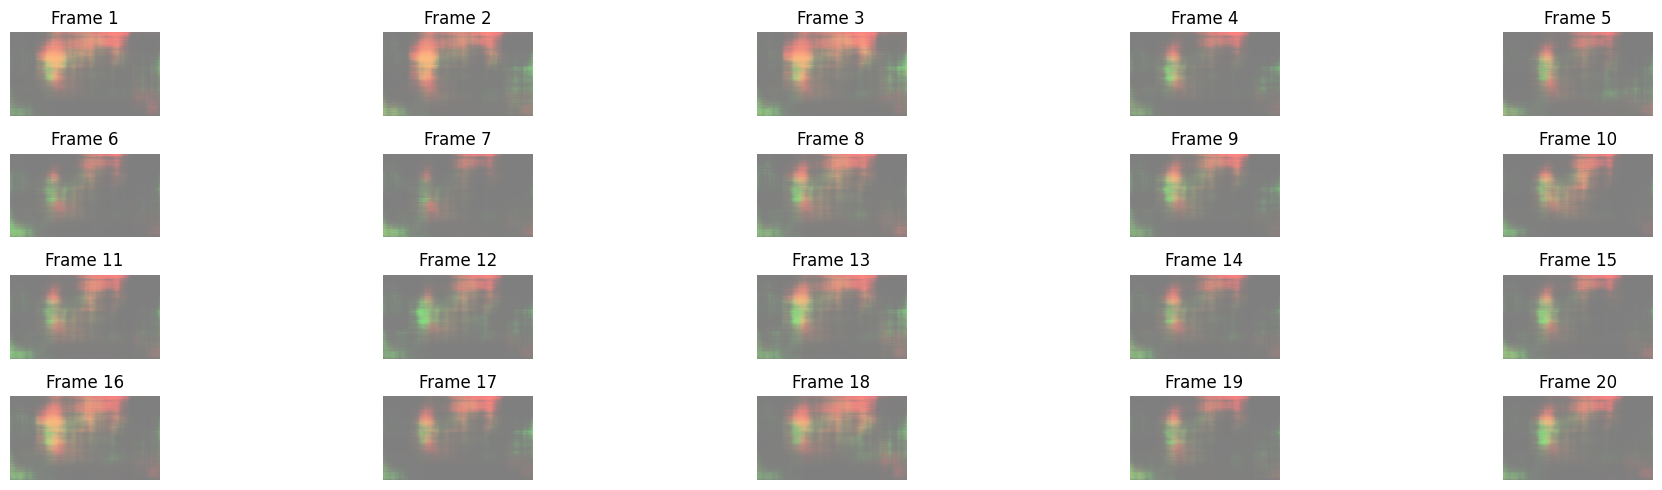

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import argparse
import json
import os
from PIL import Image
import wandb


def factorize_with_smallest_difference(n):
    factors = []

    for i in range(1, int(n ** 0.5) + 1):
        if n % i == 0:
            factors.append((i, n // i))

    best_factors = min(factors, key=lambda pair: abs(pair[0] - pair[1]))

    return best_factors


"""parser = argparse.ArgumentParser()
parser.add_argument('--path', type=str, default='views')
parser.add_argument('--cuda', action='store_true')
parser.add_argument('--n-frames', type=int)
parser.add_argument('--wandb', type=str, default=None, help="name of wandb project to log this to")
parser.add_argument('--n-image-splits', type=int, default=1, help="number of times the input that produces an image should be split (because out of gpu ram or something")
args = parser.parse_args()"""
args = argparse.Namespace(
    path='views',
    cuda=True,
    n_frames=20,
    wandb="arxiv_2006_10739",
    n_image_splits=8
)

assert not args.cuda or torch.cuda.is_available(), "Cuda is not available. Make sure you have pytorch installed with cuda or run this file without --cuda to use cpu instead."

with torch.no_grad():
    model = torch.load('3d/model.ckpt')

    # get the image size (=resolution)
    json_fn = None
    for fn in os.listdir(f"3d/{args.path}/"):
        if fn.endswith('.json'):
            assert json_fn is None, "More than one json file in data directory. Remove all but the necessary one."
            json_fn = fn

    assert json_fn is not None, "Could not find a json file containing dataset info"

    with open(f"3d/{args.path}/{json_fn}") as f:
        data_json = json.load(f)

    img_path = data_json[0]['image']
    resolution = Image.open('3d/' + img_path).size

    grid_ins = torch.stack(
        [
            torch.linspace(-1, 1, resolution[0]).unsqueeze(-1).repeat_interleave(resolution[1], dim=1),
            torch.linspace(-1, 1, resolution[1]).unsqueeze(0).repeat_interleave(resolution[0], dim=0)
        ],
        dim=-1
    )
    grid_ins = list(grid_ins.split(grid_ins.shape[0] // args.n_image_splits))
    if args.cuda:
        model = model.to('cuda')
        for i in range(len(grid_ins)):
            grid_ins[i] = grid_ins[i].to('cuda')

    # Empty function for feeding data through the model
    def predict_view(position, rotation):
        outs = []
        for grid_in in grid_ins:
            model_in = (torch.tensor(position + rotation, dtype=torch.float32)
                        .view((1, 1, -1))
                        .repeat_interleave(grid_in.shape[0], dim=0)
                        .repeat_interleave(grid_in.shape[1], dim=1))
            if args.cuda:
                model_in = model_in.to('cuda')
            model_in = torch.concat([model_in, grid_in], dim=-1)
            model_in = model_in.unsqueeze(0)
            model_out = (model(model_in) + 1) / 2
            del model_in
            outs.append(model_out.squeeze(0).to('cpu').detach())
            del model_out
        out = torch.concat(outs)
        del outs
        return out.transpose(1, 0).numpy()


    if args.wandb is not None:
        wandb.login(anonymous='allow')
        wandb.init(
            project=args.wandb
        )

    # Parameters for the animation
    num_frames = args.n_frames
    radius = 5.0
    angle_steps = np.linspace(0, 2 * np.pi, num_frames)

    # Initialize figure and 3D axes
    num_rows, num_cols = factorize_with_smallest_difference(num_frames)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))

    # List to store frames
    animation_frames = []

    # Generate camera positions and rotations
    camera_positions = [
        [radius * np.cos(angle), radius * np.sin(angle), 3.0]
        for angle in angle_steps
    ]
    camera_rotations = [
        [0, 0, np.arctan2(-position[1], -position[0])]
        for position in camera_positions
    ]

    wandb_image_table = wandb.Table(columns=["frames"])  # only used if wandb project name was provided using --wandb

    # Generate images using the model for each camera position and rotation
    for frame in range(num_frames):
        camera_position = camera_positions[frame]
        camera_rotation = camera_rotations[frame]

        # Feed camera data through the model and get the generated image
        generated_image = predict_view(camera_position, camera_rotation)
        if args.wandb is not None:
            wandb_img = wandb.Image(generated_image)
            wandb_image_table.add_data(wandb_img)

        # Display the generated image in the respective subplot
        if num_frames > 1:
            ax = axes[frame // num_cols, frame % num_cols]
        else:
            ax = axes  # Handle the case when there's only one frame

        ax.imshow(generated_image)
        ax.set_title(f'Frame {frame + 1}')
        ax.axis('off')

    if args.wandb is not None:
        wandb.log({'animation/images': wandb_image_table})
        wandb.finish()

    # Adjust layout to prevent overlapping titles and labels
    plt.tight_layout()

    # Show the plot
    plt.show()
